In [1]:
import simglucose
from simglucose.simulation.scenario import CustomScenario
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from collections import namedtuple, deque
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Filter out deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

TODO: In testing the paper does a --> B. Step 2: Personalization of DQN-Learning Models on Patient-Specific Data.


#### Classes and Fuctions

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
def paper_reward_function(BG_last_hour):
    G = BG_last_hour[-1]
    if G >= 70 and G <= 180:
        return 0.5
    if G > 180 and G <= 200:
        return -0.9
    if G > 200 and G <= 250:
        return -1.2
    if G > 250 and G <= 350:
        return -1.5
    if G > 30 and G < 70:
        return -1.8
    else:
        return -2

In [5]:
def create_env(name):

    env = gym.make(name)

    env = FlattenObservation(env)

    return env

In [6]:
class DQNNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class DDQNAgent:
    def __init__(
        self,
        input_size,
        output_size,
        gamma=0.95,
        learning_rate=0.001,
        buffer_size=800,
        batch_size=32,
    ):
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Epsilon-greedy exploration
        self.epsilon_start = 1.0
        self.epsilon_end = 0.1
        self.epsilon_decay_episodes = 30

        self.epsilon = self.epsilon_start

        # Q-networks
        self.q_network = DQNNetwork(input_size, output_size).to(self.device)
        self.target_q_network = DQNNetwork(input_size, output_size).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Experience replay buffer
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state, env):
        if np.random.rand() < self.epsilon:
            action = env.action_space.sample()
        else:
            # Exploit: choose the action with the highest Q-value
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            action = q_values.argmax().item()

        return action

    # Update epsilon during training
    def update_epsilon(self, episode):
        # Linear decay from epsilon_start to epsilon_end over epsilon_decay_episodes
        self.epsilon = max(self.epsilon_end, self.epsilon_start - (episode / self.epsilon_decay_episodes))

    def store_transition(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.replay_buffer.append(transition)

    def sample_batch(self):
        batch = random.sample(
            self.replay_buffer, min(len(self.replay_buffer), self.batch_size)
        )
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and handle dimensions
        states = torch.stack([torch.FloatTensor(state) for state in states])
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.stack(
            [torch.FloatTensor(next_state) for next_state in next_states]
        )
        dones = torch.FloatTensor(dones).unsqueeze(1)

        return states, actions, rewards, next_states, dones

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.sample_batch()
        # put all to device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions)

        # Compute target Q-values using the target network
        target_q_values = (
            rewards
            + (1 - dones)
            * self.gamma
            * self.target_q_network(next_states).max(1)[0].detach().unsqueeze(1)
        )
     
        # Compute the Huber loss
        loss = F.smooth_l1_loss(q_values, target_q_values)

        # Update the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        # Update the target network by copying the Q-network parameters
        self.target_q_network.load_state_dict(self.q_network.state_dict())

    def train_step(self, state, action, reward, next_state, done):
        # Store the transition in the replay buffer
        self.store_transition(state, action, reward, next_state, done)

        # Update the Q-network
        self.update_q_network()

        # Update the target Q-network periodically
        if len(self.replay_buffer) % 50 == 0:
            self.update_target_q_network()

In [8]:
class FlattenAction(gym.ActionWrapper):
    """Action wrapper that flattens the action."""

    def __init__(self, env):
        super(FlattenAction, self).__init__(env)
        self.action_space = gym.spaces.utils.flatten_space(self.env.action_space)

    def action(self, action):
        return gym.spaces.utils.unflatten(self.env.action_space, action)

    def reverse_action(self, action):
        return gym.spaces.utils.flatten(self.env.action_space, action)

In [9]:
def evaluate_policy(policy, env_name, seed, eval_episodes=10):
    avg_reward = 0.0
    memory=ReplayMemory(800)

    for episode in range(eval_episodes):
        state, info = env_name.reset()
        done = False

        for _ in range(max_timesteps):
            action = policy.select_action(state)
            state, reward, done, _, info = env_name.step(action)
            memory.push(state, action, reward, state, done, episode+1)

            avg_reward += reward

            if done:
                break

    avg_reward /= eval_episodes
    return memory, avg_reward


#### Training

In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done', 'episode'))

In [11]:
adolescents = [f"adolescent#{i:03d}" for i in range(1, 11)]
child = [f"child#{i:03d}" for i in range(1, 11)]
adults = [f"adult#{i:03d}" for i in range(1, 11)]


gym.envs.register(
    id="simglucose-bolus-adolescent",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": adolescents,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-child",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": child,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-adults",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": adults,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)

In [12]:
# create train env
env_adolescent = create_env('simglucose-bolus-adolescent')
env_child = create_env('simglucose-bolus-child')
env_adult = create_env('simglucose-bolus-adults')

In [13]:
# DDQ Agent setup
def setup_ddqn_agent(env):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print('state_size', state_size)
    print('action_size', action_size)
    agent = DDQNAgent(input_size=state_size, output_size=action_size)
    return agent


In [14]:
replay_memory_size = 800
memory_adult = ReplayMemory(replay_memory_size)
memory_adolescents = ReplayMemory(replay_memory_size)
memory_child = ReplayMemory(replay_memory_size)

In [27]:
num_episodes = 100

def train(env, agent):
    #fill buffer with random actions
    state, _ = env.reset()
    for i in range(replay_memory_size):    
        action = env.action_space.sample()
        next_state, reward, done, _, info = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        state = next_state
        if done:
            state, _ = env.reset()
    print('buffer filled with random actions')

    avg_reward=[]
    
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        done = False

        clock = 0
        # step is 5min in simglucose. paper let run for 60 days max
        # End the episode if the environment signals that it's done
        while not done and clock < 17280:
            action = agent.select_action(state, env)

            # Take the selected action in the environment
            next_state, reward, done, _, info = env.step(action)
            clock += 1

            # Store the transition and perform a training step
            agent.train_step(state, action, reward, next_state, done)

            state = next_state

            # Accumulate the total reward
            total_reward += reward

            #calculate the average reward
            average_reward = total_reward / clock

        # Update epsilon
        agent.update_epsilon(episode)
        avg_reward.append(average_reward)

        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Average Reward: {average_reward}")


    return agent, avg_reward

    

state_size 5
action_size 7
buffer filled with random actions
Episode 1, Total Reward: -37.69999999999995, Average Reward: -0.18756218905472613
Episode 2, Total Reward: -25.20000000000002, Average Reward: -0.13548387096774206
Episode 3, Total Reward: -19.299999999999994, Average Reward: -0.12866666666666662
Episode 4, Total Reward: -35.799999999999876, Average Reward: -0.10317002881844345
Episode 5, Total Reward: -311.9000000000011, Average Reward: -0.8761235955056211
Episode 6, Total Reward: -618.7999999999996, Average Reward: -0.7195348837209298
Episode 7, Total Reward: 30.00000000000005, Average Reward: 0.19736842105263191
Episode 8, Total Reward: -33.099999999999916, Average Reward: -0.1208029197080289
Episode 9, Total Reward: 63.49999999999963, Average Reward: 0.12828282828282753
Episode 10, Total Reward: -138.5999999999999, Average Reward: -0.5823529411764702
Episode 11, Total Reward: -178.10000000000025, Average Reward: -0.43228155339805885
Episode 12, Total Reward: -28.399999999

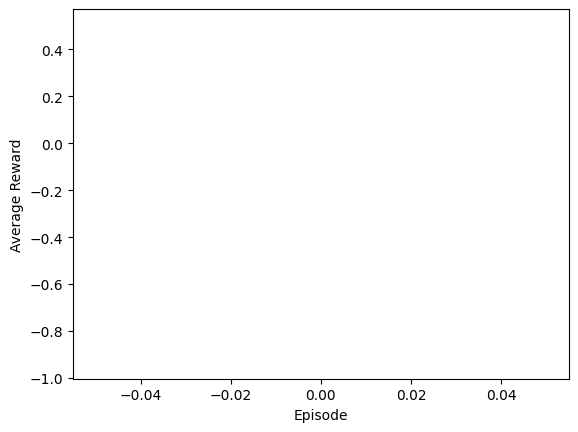

In [26]:
# train agents for all 3 age groups
agent_adult = setup_ddqn_agent(env_adult)
agent_adult, avg_reward_adult = train(env_adult, agent_adult)

In [28]:
agent_adolescent = setup_ddqn_agent(env_adolescent)
agent_adolescent, avg_reward_adolescent = train(env_adolescent, agent_adolescent)


state_size 5
action_size 7
buffer filled with random actions
Episode 1, Total Reward: -362.7000000000039, Average Reward: -0.1672970479704815
Episode 2, Total Reward: -15.100000000000001, Average Reward: -0.1372727272727273
Episode 3, Total Reward: -132.09999999999988, Average Reward: -0.6443902439024385
Episode 4, Total Reward: 42.20000000000002, Average Reward: 0.17881355932203397
Episode 5, Total Reward: 23.400000000000073, Average Reward: 0.12580645161290363
Episode 6, Total Reward: -42.899999999999984, Average Reward: -0.25843373493975896
Episode 7, Total Reward: 79.30000000000005, Average Reward: 0.2937037037037039
Episode 8, Total Reward: 7.100000000000024, Average Reward: 0.025724637681159505
Episode 9, Total Reward: -290.80000000000166, Average Reward: -0.4226744186046536
Episode 10, Total Reward: 52.3, Average Reward: 0.19661654135338344
Episode 11, Total Reward: -6.9999999999999645, Average Reward: -0.03167420814479622
Episode 12, Total Reward: 22.700000000000095, Average Re

In [ ]:
agent_child = setup_ddqn_agent(env_child)
agent_child, avg_reward_child = train(env_child, agent_child)

In [ ]:
evaluate_policy(agent_adult, 'simglucose-bolus-adults', 1, eval_episodes=10, max_timesteps=1000)

In [ ]:
#state
#observation [GCM, CHO, Insulin]

In [ ]:
# plot the average reward per episode in training for all 3 age groups
rewards = [transition.reward for transition in memory.memory]
num_episodes = 100
average_reward = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)

plt.plot(average_reward)
plt.xlabel("Episode")
plt.ylabel("Average Reward")

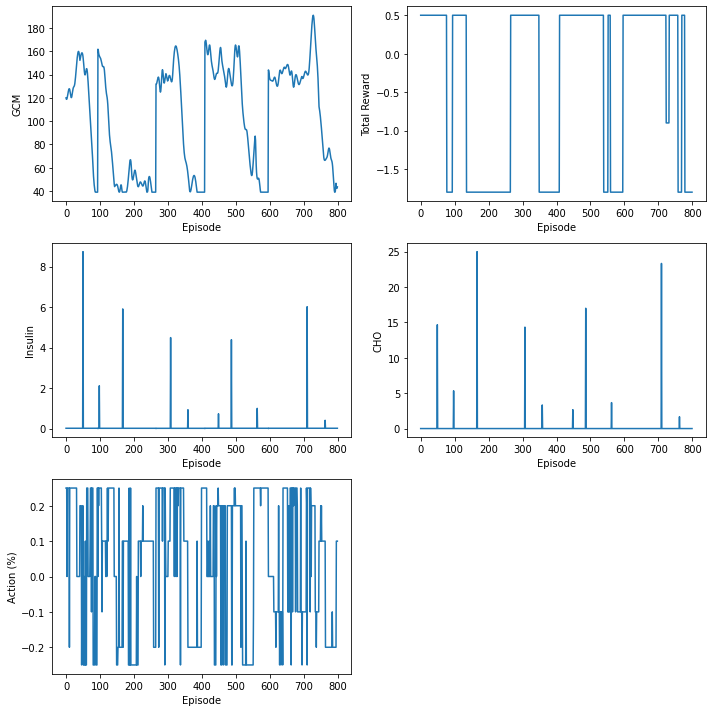

In [ ]:
for agent, memory, env_name in [
    (agent_adult, memory_adult, "simglucose-bolus-adults"),
    (agent_adolescent, memory_adolescents, "simglucose-bolus-adolescent"),
    (agent_child, memory_child, "simglucose-bolus-child"),
]:
    # Evaluate the agent
    avg_reward = evaluate_policy(agent, env_name, seed=0, eval_episodes=10)
    print(f"Average Reward: {avg_reward:.2f}")

    # Save the agent
    torch.save(agent.q_network.state_dict(), f"agent_{env_name}.pt")

    # Save the memory
    torch.save(memory, f"memory_{env_name}.pt")

    # # Load the agent
    # agent.q_network.load_state_dict(torch.load(f"agent_{env_name}.pt"))

    # # Load the memory
    # memory = torch.load(f"memory_{env_name}.pt")
    # visualize results from the memory
    plt.figure(figsize=(10, 10))
    #set overall title
    plt.suptitle(f"Results for {env_name}", fontsize=16)
    plt.subplot(3, 2, 1)
    gcm_values = [transition.state[0] for transition in memory.memory]

    plt.plot(gcm_values)
    plt.xlabel("Episode")
    plt.ylabel("GCM")

    plt.subplot(3, 2, 2)
    rewards = [transition.reward for transition in memory.memory]

    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    plt.subplot(3, 2, 3)
    insulin_values = [transition.state[2] for transition in memory.memory]

    plt.plot(insulin_values)
    plt.xlabel("Episode")
    plt.ylabel("Insulin")

    plt.subplot(3, 2, 4)
    cho_values = [transition.state[1] for transition in memory.memory]

    plt.plot(cho_values)
    plt.xlabel("Episode")
    plt.ylabel("CHO")

    plt.subplot(3, 2, 5)
    # visualize the actions taken
    actions_idx = [transition.action for transition in memory.memory]

    actions_percentage = np.array([0.75, 0.8, 0.9, 1, 1.1, 1.2, 1.25]) - 1
    actions = actions_percentage[actions_idx]

    plt.plot(actions)
    plt.xlabel("Episode")
    plt.ylabel("Action (%)")

    plt.tight_layout()
    plt.show()
    #'state', 'action', 'next_state', 'reward', 'done', 'episode'

In [ ]:
avg_reward =evaluate_policy(agent, "simglucose-bolus", 0)

In [ ]:
avg_reward	

-18.510000000000208

Evaluation Metrics: 
- Section V. A:  we de- rived three metrics related to the the percentage of time spent within the different glycemic ranges, that is the normoglycemic range (TIR), i.e., 70 ≤ CGM ≤ 180 mg/dL, below this range (TBR), i.e., CGM < 70 mg/dL, and above this range (TAR), i.e., CGM > 180 mg/dL. 
- Figure 4